# Introduction: Book Recommendation System

In this notebook, we will build a book recommendation system based on all the books articles on Wikipedia and neural network embeddings of books and links. This is a great look at the potential for neural networks to create meaningful embeddings of high dimensional data and one practical application of deep learning.

Adapted from the [Deep Learning Cookbook notebooks](https://github.com/DOsinga/deep_learning_cookbook). Check out this book for practical applications of deep learning and great projects! 

## Read in Data

The data is stored as json with line for every book. This data contains every single book article on Wikipedia which was parsed in the Downloading and Parsing Wikipedia Data Notebook.

In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import json

books = []

with open('found_books_filtered.ndjson', 'r') as fin:
    # Append each line to the books
    books = [json.loads(l) for l in fin]

books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
print(f'Found {len(books)} books.')

Found 37020 books.


In [3]:
[book[0] for book in books_with_wikipedia][:5]

['Wikipedia:Wikipedia Signpost/2014-06-25/Recent research',
 'Wikipedia:New pages patrol/Unpatrolled articles/December 2010',
 'Wikipedia:Templates for discussion/Log/2012 September 23',
 'Wikipedia:Articles for creation/Redirects/2012-10',
 'Wikipedia:Templates for discussion/Log/2012 October 4']

Each book contains the title, the information from the `Infobox book` template, the internal wikipedia links, the external links, the date of last edit, and the number of characters in the article (a rough estimate of the length of the article).

In [4]:
books[15]

['Derech Mitzvosecha',
 {'author': 'Rabbi Menachem Mendel Schneersohn ( " Tzemach Tzedek " ), the third Rebbe of Chabad',
  'caption': 'Derech Mitzvosecha, 1912 edition',
  'genre': 'non-fiction',
  'image': 'Derech Mitzvosecha 2014-05-08 01-34.jpg',
  'image_size': '200px',
  'isbn': '0826655904',
  'language': 'Hebrew',
  'name': 'Derech Mitzvosecha (Sefer Hamitzvos)',
  'published': '7x10 Hardcover, 570pp, (Kehot Publication Society, Brooklyn New York)',
  'subject': 'Jewish mysticism, Chabad philosophy'},
 ['Mitzvos',
  'Menachem Mendel Schneersohn',
  'Rebbe',
  'Chabad',
  'Hasidic',
  'Chabad philosophy',
  'Tzitzit',
  'Tefillin',
  'Hillel the Elder',
  'Poltava',
  'Kehot Publication Society',
  'Eliyahu Touger',
  'Sichos in English',
  'Tanya',
  'Shneur Zalman of Liadi',
  'Category:Chabad-Lubavitch (Hasidic dynasty)',
  'Category:Books about Judaism',
  'Category:Chabad-Lubavitch texts'],
 ['http://www.books.google.com/books?id=HYLi3l9ylWwC',
  'http://www.store.kehotonli

# Map Books to Integers

First we want to create a mapping of books to integers. When we feed books into the neural network, we will have to represent them as numbers, so this mapping will let us keep track of the books.

In [5]:
book_index = {book[0]: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}

book_index['War and Peace']
index_book[22460]

22460

'War and Peace'

# Number of Unique Wikilinks

First we can do a little data exploration. Let's find the number of unique Wikilinks (links to other Wikipedia articles) and the most common ones. To create a single list from a list of lists, we can use the `itertools` chain method.

In [6]:
from itertools import chain

wikilinks = list(chain(*[book[2] for book in books]))
print(f"There are {len(set(wikilinks))} unique wikilinks.")

There are 311276 unique wikilinks.


How many of these are links to other books? 

In [7]:
wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]
print(f"There are {len(set(wikilinks_other_books))} unique links to other books.")

There are 17032 unique links to other books.


Let's take a look at the counts of each wikilink. We'll make a utility function that takes in a list and returns a sorted ordered dictionary of the counts of the items in the list.

In [8]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

In [9]:
wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 7641),
 ('Paperback', 7482),
 ('Wikipedia:WikiProject Books', 6116),
 ('Wikipedia:WikiProject Novels', 6087),
 ('English language', 4307),
 ('The New York Times', 3960),
 ('United States', 3388),
 ('Science fiction', 3121),
 ('science fiction', 2661),
 ('Publishers Weekly', 2414)]

The most linked to pages are in fact not that surprising! One thing we should notice is that there are discrepancies in capitalization. We want to normalize across capitalization, so we'll lowercase all of the links and redo the counts.

In [10]:
wikilinks = [link.lower() for link in wikilinks]
print(f"There are {len(set(wikilinks))} unique wikilinks.")

There are 297624 unique wikilinks.


In [11]:
wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]

[('paperback', 8976),
 ('hardcover', 8854),
 ('wikipedia:wikiproject books', 6116),
 ('wikipedia:wikiproject novels', 6088),
 ('science fiction', 5917),
 ('english language', 4371),
 ('the new york times', 3976),
 ('united states', 3391),
 ('novel', 3044),
 ('publishers weekly', 2414)]

That actually changes the rankings! This illustrates an important point: make sure to take a look at your data before modeling! 

In [12]:
wikilinks_other_books = [link.lower() for link in wikilinks_other_books]
wikilink_books_counts = count_items(wikilinks_other_books)
list(wikilink_books_counts.items())[:10]

[('the discontinuity guide', 148),
 ('the encyclopedia of science fiction', 145),
 ('dracula', 72),
 ('the dresden files', 70),
 ('the encyclopedia of fantasy', 66),
 ('encyclopædia britannica', 61),
 ('the wonderful wizard of oz', 61),
 ('nineteen eighty-four', 59),
 ("alice's adventures in wonderland", 54),
 ('don quixote', 52)]

Since there are so many unique wikilinks, I'm going to limit the list to wikilinks mentioned 5 or more times. Hopefully this reduces the noise that might come from wikilinks that only appear a few times.

In [13]:
links = [t[0] for t in wikilink_counts.items() if t[1] >= 5]
print(len(links))
links[-10:]

38554


['catherine ryan hyde',
 'life with billy (book)',
 'shan states',
 'burmese chronicles#ramanya',
 'northern ndebele people',
 'international journal of hindu studies',
 'charles henderson (character)',
 'anarchy: a journal of desire armed',
 'american museum of fly fishing',
 'key of perihelion']

The pound sign in the link name means that the link directs to a specific section on the Wikipedia page. Although we could normalize these to the title of the wikipedia article, we'll leave the pound sign in for now.

I'm also going to remove the __most popular__ wikilinks because these are not very informative. If a large number of books have the same wikilink, then the wikilink is not very distinguishing. 

In [14]:
to_remove = ['hardcover', 'paperback', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for t in to_remove:
    links.remove(t)
    _ = wikilink_counts.pop(t)

## Wikilinks to Index

As with the books, we need to map the wikilinks to integers. We'll also create the reverse mapping.

In [15]:
link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

link_index['the new york times']
index_link[2]
len(link_index)

2

'the guardian'

38550

# Build a Training Set

In order for any machine learning model to learn, it needs a training set. We are going to treat this as a supervised learning problem: given an article, can the neural network determine whether or not a wikilink was present on that page? To do this, we need to create a dictionary of books and the associate links on their page. We already have this in the list of books, but now we need to change our data structure.

In [16]:
# book_link_mapping = {book_index[book[0]]: [link_index[link.lower()] for link in book[2] if link.lower() in links] for book in books}

# book_link_mapping = {}

# for i, book in enumerate(books):
#     book_link_mapping[book_index[book[0]]] = []
#     for link in book[2]:
#         if link.lower() in links:
#             book_link_mapping[book_index[book[0]]].append(link_index[link.lower()])
    
#     if i % 100 == 0:
#         print(i, end = '\r')

For each book and each wikilink in the books articles, we'll add it to a list of pairs with the form (book_index, link_index). We also filter out the links that did not have at least 5 occurrences.

In [17]:
pairs = []

for book in books:
    pairs.extend((book_index[book[0]], link_index[link.lower()]) for link in book[2] if link.lower() in links)
    
len(pairs), len(links), len(books)

(768821, 38550, 37020)

We now have 805304 positive examples on which to train! Each pair represents one internal wikipedia link for one book. Let's look at a few examples.

In [18]:
index_book[pairs[5000][0]], index_link[pairs[5000][1]]

("Dr. Seuss's ABC", 'dr. seuss')

In [19]:
index_book[pairs[1001][0]], index_link[pairs[1001][1]]

('Palestine: A Policy', 'methuen publishing')

## Split into Training and Validation

For training the neural network, we can split the pairs into a training set and a validation set. We want to make sure that none of the validation set is present in the training set.

In [20]:
pairs_set = set(pairs)

validation_split = int(0.2 * len(pairs))

train_pairs = pairs[validation_split:]
train_set = set(train_pairs)

valid_pairs = pairs[:validation_split]
valid_pairs = [pair for pair in valid_pairs if pair not in train_set]

len(train_pairs), len(valid_pairs)

(615057, 153763)

In [21]:
x = Counter(pairs)
sorted(x.items(), key = lambda x: x[1], reverse = True)[:5]

[((13337, 725), 85),
 ((31899, 40), 77),
 ((5919, 1884), 62),
 ((25899, 1395), 61),
 ((10394, 1955), 60)]

In [22]:
index_book[13337], index_link[725]

("France's Songs of the Bards of the Tyne - 1850", 'joseph philip robson')

In [23]:
index_book[31899], index_link[40]

('The Early Stories: 1953–1975', 'the new yorker')

The more common wikilinks might be less useful. In a way, this could be similar to problem that creates a need for TF-IDF: the more common a word, the less representative it is of the sentence.

## Generator For Training Samples

We want to generate positive samples and negative samples. The positive samples are simple: pick one random pair from the `pairs` and assign it a 1. The negative samples are also fairly easy: pick one random link and one random book, make sure they are not in the `pairs`, and assign them a -1.

In [24]:
import numpy as np
import random
random.seed(100)

def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0, accuracy = False):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    if accuracy:
        neg_label = 0
    else:
        neg_label = -1
    
    while True:
        # randomly choose positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (book_id, link_id, 1)
            
        idx = n_positive
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_book = random.randrange(len(books))
            random_link = random.randrange(len(links))
            
            # Check to make sure this is not a positive example
            if (random_book, random_link) not in pairs_set:
                batch[idx, :] = (random_book, random_link, neg_label)
                idx += 1
                
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

In [25]:
next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

({'book': array([ 7206., 28410., 29814.,  6917., 22239., 25757.]),
  'link': array([34924., 33217., 11452., 21344.,  6046., 22920.])},
 array([-1., -1., -1.,  1.,  1., -1.]))

## Book Embedding Model

In [26]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

C:\Users\willk\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [27]:
def book_embedding_model(embedding_size = 50, accuracy = False):
    book = Input(name = 'book', shape = [1])
    link = Input(name = 'link', shape = [1])
    
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book)
    
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)
    
    book_embedding = Reshape(target_shape = [embedding_size])(book_embedding)
    link_embedding = Reshape(target_shape = [embedding_size])(link_embedding)
    
    merged = Dot(name = 'dot_product', normalize = True, axes = 1)([book_embedding, link_embedding])
    
    if accuracy:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    else:
#         merged = Dense(1, activation = None)(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

model = book_embedding_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
link (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 50)        1851000     book[0][0]                       
__________________________________________________________________________________________________
link_embedding (Embedding)      (None, 1, 50)        1927500     link[0][0]                       
__________________________________________________________________________________________________
reshape_1 

# Train Model

The next step is just to train the model. We can fit the model on the generator and also make a generator for validation. 

In [28]:
n_positive = 512

gen = generate_batch(pairs, n_positive, negative_ratio = 5)
train_gen = generate_batch(train_pairs, n_positive, negative_ratio=5)
valid_gen = generate_batch(valid_pairs, n_positive, negative_ratio=5)

model.fit_generator(gen, epochs = 20, 
                    steps_per_epoch = len(pairs) // n_positive,
                    verbose = 2)

Epoch 1/20
 - 34s - loss: 0.8293
Epoch 2/20
 - 32s - loss: 0.3782
Epoch 3/20
 - 31s - loss: 0.3521
Epoch 4/20
 - 32s - loss: 0.3396
Epoch 5/20
 - 33s - loss: 0.3353
Epoch 6/20
 - 35s - loss: 0.3306
Epoch 7/20
 - 35s - loss: 0.3258
Epoch 8/20
 - 35s - loss: 0.3235
Epoch 9/20
 - 35s - loss: 0.3219
Epoch 10/20
 - 35s - loss: 0.3208
Epoch 11/20
 - 35s - loss: 0.3202
Epoch 12/20
 - 35s - loss: 0.3194
Epoch 13/20
 - 35s - loss: 0.3194
Epoch 14/20
 - 35s - loss: 0.3198
Epoch 15/20
 - 35s - loss: 0.3178
Epoch 16/20
 - 35s - loss: 0.3171
Epoch 17/20
 - 35s - loss: 0.3164
Epoch 18/20
 - 35s - loss: 0.3166
Epoch 19/20
 - 35s - loss: 0.3154
Epoch 20/20
 - 35s - loss: 0.3150


In [29]:
model.save('first_attempt.h5')

## Extract Embeddings

In [30]:
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape

(37020, 50)

We need to normalize the embeddings so that the dot product between two embeddings becomes the cosine similarity.

In [31]:
book_weights = book_weights / np.linalg.norm(book_weights, axis = 1).reshape((-1, 1))
np.sum(np.square(book_weights[0]))

0.99999994

In [122]:
def find_similar(name, weights, index_name = 'book', n = 10, least = False, return_dist = False):
    """Find n most similar items (or least) to name based on embeddings"""
    
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'link':
        index = link_index
        rindex = index_link
    
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # If specified, find the least similar
    if least:
        closest = np.argsort(dists)[:n]
        
    # Otherwise find the most similar
    else:
        closest = np.argsort(dists)[-n:]
    
    
    
    if return_dist:
        return dists, closest
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Distance: {dists[c]:.{2}}')
        
    

In [33]:
find_similar('War and Peace', book_weights)

Book: War and Peace               Distance: 1.0
Book: Anna Karenina               Distance: 0.94
Book: Candide                     Distance: 0.92
Book: The Master and Margarita    Distance: 0.91
Book: Poor Folk                   Distance: 0.9
Book: Demons (Dostoevsky novel)   Distance: 0.88
Book: Eugene Onegin               Distance: 0.87
Book: Buddenbrooks                Distance: 0.87
Book: Crime and Punishment        Distance: 0.86
Book: Dead Souls                  Distance: 0.86


It works! The most similar books make sense at least for War and Peace.

In [34]:
find_similar('War and Peace', book_weights, least = True)

Book: Twilight Zone: 19 Original Stories on the 50th Anniversary   Distance: -0.32
Book: Pitcher-Plants of Borneo                                     Distance: -0.32
Book: Player's Handbook                                            Distance: -0.34
Book: Fear (anthology)                                             Distance: -0.34
Book: Catch the Lightning                                          Distance: -0.34
Book: Handbook (LDS Church)                                        Distance: -0.36
Book: The Collected Stories of Philip K. Dick                      Distance: -0.36
Book: The Dresden Files short fiction                              Distance: -0.36
Book: Cthulhu Mythos anthology                                     Distance: -0.36
Book: List of Transformers books                                   Distance: -0.41


The least similar books are quite a grab bag!

In [35]:
find_similar('The Autobiography of Benjamin Franklin', book_weights, n = 5)

Book: The Autobiography of Benjamin Franklin           Distance: 1.0
Book: Poems on Various Subjects, Religious and Moral   Distance: 0.95
Book: Cloudsplitter                                    Distance: 0.93
Book: Leaves of Grass                                  Distance: 0.93
Book: Pudd'nhead Wilson                                Distance: 0.93


It doesn't work perfectly for every book as we can see.

In [36]:
find_similar('A More Perfect Constitution', book_weights, n = 5)

Book: A More Perfect Constitution                                  Distance: 1.0
Book: Barack Obama: The Story                                      Distance: 0.99
Book: The Promise: President Obama, Year One                       Distance: 0.99
Book: Hillary's Choice                                             Distance: 0.99
Book: Bias: A CBS Insider Exposes How the Media Distort the News   Distance: 0.99


In [37]:
find_similar('The Fellowship of the Ring', book_weights)

Book: The Fellowship of the Ring         Distance: 1.0
Book: The Return of the King             Distance: 0.97
Book: The Silmarillion                   Distance: 0.96
Book: Beren and Lúthien                  Distance: 0.95
Book: The Children of Húrin              Distance: 0.94
Book: The Two Towers                     Distance: 0.94
Book: Bored of the Rings                 Distance: 0.89
Book: The Last Ringbearer                Distance: 0.88
Book: The Lost Road and Other Writings   Distance: 0.88
Book: The History of Middle-earth        Distance: 0.87


In [38]:
find_similar('The Two Towers', book_weights)

Book: The Two Towers                         Distance: 1.0
Book: The Return of the King                 Distance: 0.97
Book: Beren and Lúthien                      Distance: 0.97
Book: The History of Middle-earth            Distance: 0.95
Book: The Book of Lost Tales                 Distance: 0.95
Book: The History of The Lord of the Rings   Distance: 0.94
Book: The Adventures of Tom Bombadil         Distance: 0.94
Book: Tales from the Perilous Realm          Distance: 0.94
Book: The Fall of Gondolin                   Distance: 0.94
Book: The Fellowship of the Ring             Distance: 0.94


## Link Embeddings

We also have the embeddings of wikipedia links. We can take a similar approach to extract these and find the most similar.

In [39]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [40]:
link_weights = extract_weights('link_embedding', model)
link_weights.shape

(38550, 50)

We can use the same find similar function to find the most similar links to a given link.

In [43]:
find_similar('science fiction', link_weights, index_name = 'link')

Link: science fiction                            Distance: 1.0
Link: category:american science fiction novels   Distance: 0.96
Link: fantasy                                    Distance: 0.89
Link: tor books                                  Distance: 0.86
Link: doubleday (publisher)                      Distance: 0.85
Link: united states                              Distance: 0.84
Link: bantam books                               Distance: 0.84
Link: category:doubleday (publisher) books       Distance: 0.84
Link: english language                           Distance: 0.82
Link: novel                                      Distance: 0.81


In [44]:
find_similar('biography', link_weights, index_name = 'link')

Link: biography                             Distance: 1.0
Link: autobiography                         Distance: 0.89
Link: category:american non-fiction books   Distance: 0.88
Link: non-fiction                           Distance: 0.87
Link: category:2005 books                   Distance: 0.85
Link: category:english-language books       Distance: 0.84
Link: category:2008 books                   Distance: 0.83
Link: category:2010 non-fiction books       Distance: 0.83
Link: memoir                                Distance: 0.82
Link: category:2006 books                   Distance: 0.82


## Model For Accuracy

In [45]:
model_acc = book_embedding_model(50, True)

gen = generate_batch(pairs, n_positive=512, negative_ratio=2, accuracy = True)
train_gen_acc = generate_batch(train_pairs, n_positive=512, negative_ratio=1, accuracy = True)
valid_gen_acc = generate_batch(valid_pairs, n_positive=512, negative_ratio=1, accuracy = True)

In [46]:
model_acc.fit_generator(gen, epochs = 15, steps_per_epoch=1000,
                        validation_data = valid_gen_acc, 
                        validation_steps = 10, verbose = 0)

In [47]:
book_weights_acc = extract_weights('book_embedding', model_acc)
book_weights_acc.shape

(37020, 50)

In [48]:
model.save('first_attempt_acc.h5')

In [49]:
find_similar('War and Peace', book_weights_acc)

Book: War and Peace               Distance: 1.0
Book: Anna Karenina               Distance: 0.78
Book: Demons (Dostoevsky novel)   Distance: 0.78
Book: Doctor Zhivago (novel)      Distance: 0.77
Book: Crime and Punishment        Distance: 0.71
Book: The Master and Margarita    Distance: 0.7
Book: Torrents of Spring          Distance: 0.68
Book: The Idiot                   Distance: 0.66
Book: Fathers and Sons (novel)    Distance: 0.65
Book: The Brothers Karamazov      Distance: 0.63


In [50]:
find_similar('The Fellowship of the Ring', book_weights_acc)

Book: The Fellowship of the Ring   Distance: 1.0
Book: The Return of the King       Distance: 0.91
Book: The Two Towers               Distance: 0.88
Book: The Silmarillion             Distance: 0.79
Book: The Last Ringbearer          Distance: 0.78
Book: The Fall of Gondolin         Distance: 0.74
Book: Beren and Lúthien            Distance: 0.73
Book: Morgoth's Ring               Distance: 0.73
Book: The War of the Jewels        Distance: 0.72
Book: Unfinished Tales             Distance: 0.72


In [51]:
link_weights_acc = extract_weights('link_embedding', model_acc)

In [52]:
find_similar('new york times', link_weights_acc, index_name = 'link', n = 5)

Link: new york times       Distance: 1.0
Link: the new york times   Distance: 0.96
Link: random house         Distance: 0.91
Link: los angeles times    Distance: 0.91
Link: publishers weekly    Distance: 0.9


In [53]:
find_similar('category:1964 fantasy novels', link_weights_acc, index_name = 'link', n = 5)

Link: category:1964 fantasy novels       Distance: 1.0
Link: beyond the farthest star (novel)   Distance: 0.79
Link: the resurrection of jimber-jaw     Distance: 0.76
Link: roy krenkel                        Distance: 0.74
Link: giovanni virginio schiaparelli     Distance: 0.73


# Visualizations

One of the coolest part about embeddings is that we can visualize them. First we have to take them from 50 dimensions down to either 3 or 2. We can do this using `pca`, `tsne`, or `umap`. We'll try both tsne and umap for comparison.

In [54]:
from sklearn.manifold import TSNE
from umap import UMAP

In [61]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    if method == 'tsne':
        return TSNE(components).fit_transform(weights)
    elif method == 'umap':
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 2).fit_transform(weights)

In [56]:
# book_r = reduce_dim(book_weights_acc, components = 2, method = 'tsne')
# book_r.shape

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

plt.plot(book_r[:, 0], book_r[:, 1], 'r.')

NameError: name 'book_r' is not defined

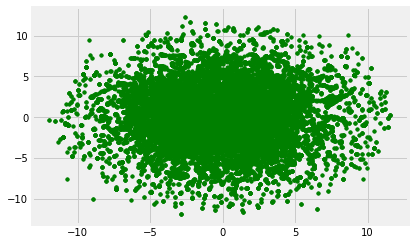

In [88]:
book_ru = reduce_dim(book_weights_acc, components = 2, method = 'umap')
plt.plot(book_ru[:, 0], book_ru[:, 1], 'g.');

### Book Embeddings by Category

This is a little hard to interpret. Let's take the 10 most popular categories, and color the image by the category.

In [89]:
categories = [[link for link in book[2] if 'Category:' in link] for book in books]
c_counts = count_items(list(chain(*categories)))
list(c_counts.items())[:5]

[('Category:American science fiction novels', 1289),
 ('Category:American novels adapted into films', 1139),
 ('Category:Debut novels', 1072),
 ('Category:American fantasy novels', 1036),
 ('Category:American young adult novels', 956)]

We'll stick to the 10 most popular categories. 

In [90]:
c_to_include = list(c_counts.keys())[:10]
c_to_include = [c.lower() for c in c_to_include]
c_to_include[:5]

['category:american science fiction novels',
 'category:american novels adapted into films',
 'category:debut novels',
 'category:american fantasy novels',
 'category:american young adult novels']

A lot of these categories have overlap and books can have multiple categories. Therefore we'll just take the first category for the book that is in the categories to include.

In [91]:
idx_include = []
cs = []

# Iterate through each book's categories
for i, book_c in enumerate(categories):
    # Iterate through books categories in the book
    for c in book_c:
        # If link is in c to include, record the index of book and category
        if c.lower() in c_to_include:
            idx_include.append(i)
            cs.append(c.lower())
            break

Now we need to map the categories to integers. 

In [92]:
ints, cats = pd.factorize(cs)
cats

array(['category:english-language books', 'category:debut novels',
       'category:american novels adapted into films',
       'category:british novels adapted into films',
       'category:novels first published in serial form',
       'category:american fantasy novels',
       'category:american young adult novels',
       'category:harpercollins books',
       'category:american science fiction novels',
       'category:american non-fiction books'], dtype=object)

Finally, we can plot the embedding colored by the category. 

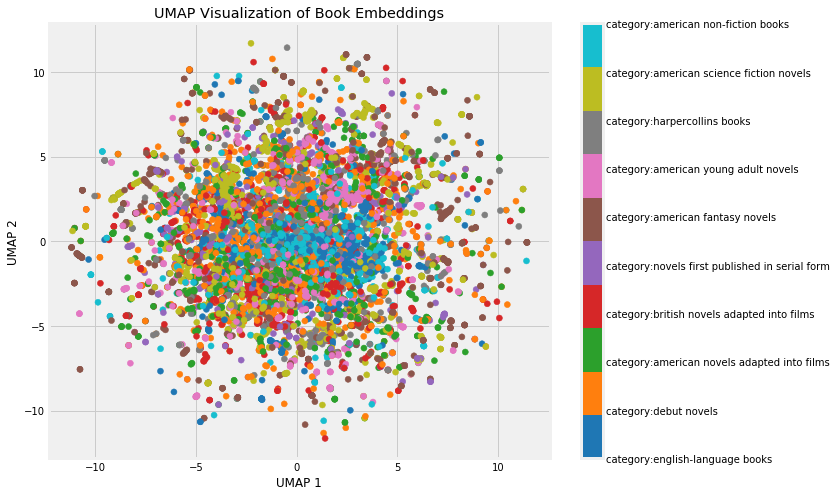

In [93]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_ru[idx_include, 0], book_ru[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks(list(range(10)))
cbar.set_ticklabels(cats)


plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('UMAP Visualization of Book Embeddings');

There doesn't appear to be much separation between the categories. There are a lot of parameters to play around with in UMAP, and changing some of them might result in better clusters.

As a last step, let's see the embedding labeled with the 10 books most often mentioned by other books.

In [106]:
wikilink_books = list(chain(*[[l for l in book[2] if l in book_index.keys()] for book in books]))
wikilink_book_counts = count_items(wikilink_books)
list(wikilink_book_counts.items())[:10]

[('The Discontinuity Guide', 148),
 ('The Encyclopedia of Science Fiction', 145),
 ('Dracula', 72),
 ('The Dresden Files', 70),
 ('The Encyclopedia of Fantasy', 66),
 ('Encyclopædia Britannica', 61),
 ('The Wonderful Wizard of Oz', 61),
 ('Nineteen Eighty-Four', 59),
 ("Alice's Adventures in Wonderland", 54),
 ('Don Quixote', 52)]

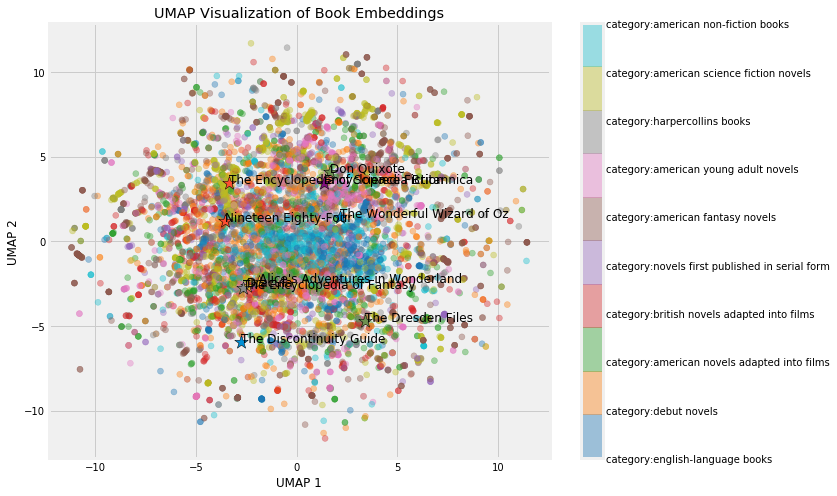

In [117]:
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_ru[idx_include, 0], book_ru[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10, alpha = 0.4)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks(list(range(10)))
cbar.set_ticklabels(cats)


plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('UMAP Visualization of Book Embeddings');

for book in list(wikilink_book_counts.keys())[:10]:
    
    x, y = book_ru[book_index[book], 0], book_ru[book_index[book], 1];
    _ = plt.scatter(x, y, s = 200, marker = '*', edgecolor = 'k')
    _ = plt.text(x, y, book, fontsize = 12);


## Plot Book Nearest Neighbors

To get a better sense of which books are located where, we can plot a book along with its nearest neighbors. These will be the nearest neighbors in the original embedding space, so they are not necessarily the closest in the reduced dimension representation.

In [123]:
dist, closest = find_similar('War and Peace', book_weights_acc, 'book', n = 10, return_dist=True)

In [221]:
def plot_closest(item, weights, index_name, n, plot_data):
    """Plot n most closest items to item"""
    
    # Find the closest items
    dist, closest = find_similar(item, weights, index_name, n, return_dist=True)
    
    # Choose mapping for look up
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'link':
        index = link_index
        rindex = index_link 
    
    plt.figure(figsize = (10, 8))
    plt.rcParams['font.size'] = 14
    
    # Limit distances
    dist = dist[closest]
    
    # Plot all of the data
    plt.scatter(plot_data[:, 0], plot_data[:, 1], alpha = 0.1, color = 'goldenrod')
    
    # Plot the item
    plt.scatter(plot_data[closest[-1], 0], plot_data[closest[-1], 1], s = 600, edgecolor = 'k', color = 'b')
    
    # Plot the closest items
    plt.scatter(plot_data[closest, 0], plot_data[closest, 1], 
                c = dist, cmap = plt.cm.copper, s = 200, alpha = 1, marker = '*')
    
    # Colorbar management
    cbar = plt.colorbar()
    cbar.set_label(f'{index_name.capitalize()} and Cosine Distance')
    cbar.set_ticks(np.linspace(dist.min(), dist.max(), 10))
    cbar.set_ticklabels([f'{rindex[idx]}: {distance:.2}' for idx, distance in zip(closest, dist)])
    
    # Labeling
    plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title(f'Most Similar {index_name.capitalize()}s to {item}')

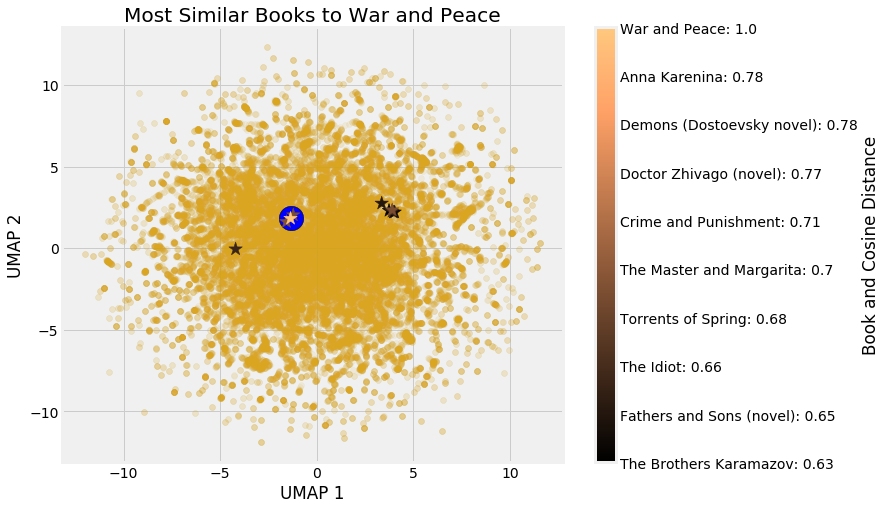

In [222]:
plot_closest('War and Peace', book_weights_acc, 'book', 10, book_ru)

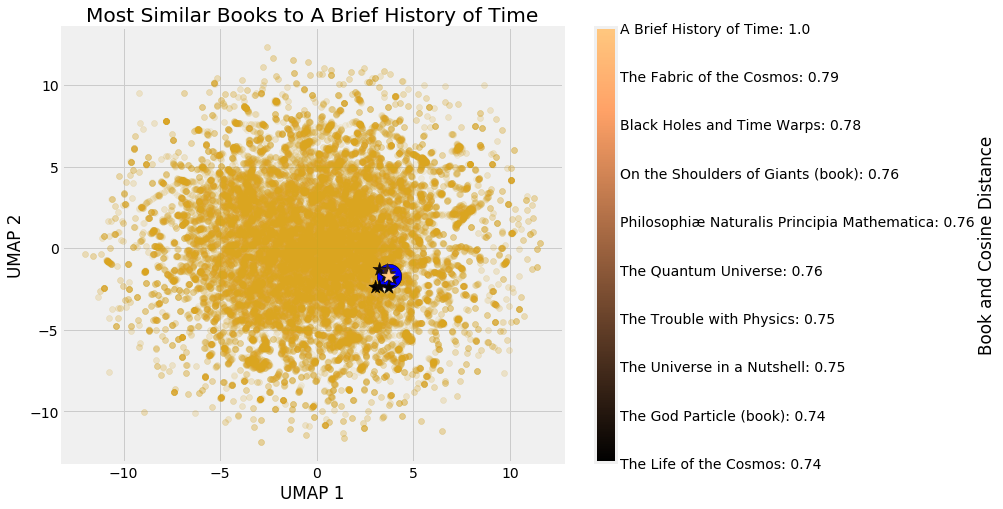

In [229]:
plot_closest('A Brief History of Time', book_weights_acc, 'book', 10, book_ru)

## Embedding Links

Let's look at reducing the dimension of the embedding for the links. We'll start with only the categories.

In [240]:
idx_to_include = [idx for link, idx in link_index.items() if 'category:' in link]
link_ru = reduce_dim(link_weights_acc[idx_to_include], components = 2, method = 'umap')
link_ru.shape

(5876, 2)

In [241]:
link_ru

array([[-6.507651  , -6.3179183 ],
       [-0.25321236, -3.075378  ],
       [-0.35242546, -3.0932374 ],
       ...,
       [ 2.223554  ,  3.375472  ],
       [ 2.5699973 ,  0.6256235 ],
       [-4.930521  ,  0.36446208]], dtype=float32)

We'll get the 10 most popular categories so we can plot them highlighted.

In [242]:
idx = []
for link in cats:
    idx.append(int(np.where(np.array(idx_to_include) == link_index[link.lower()])[0]))

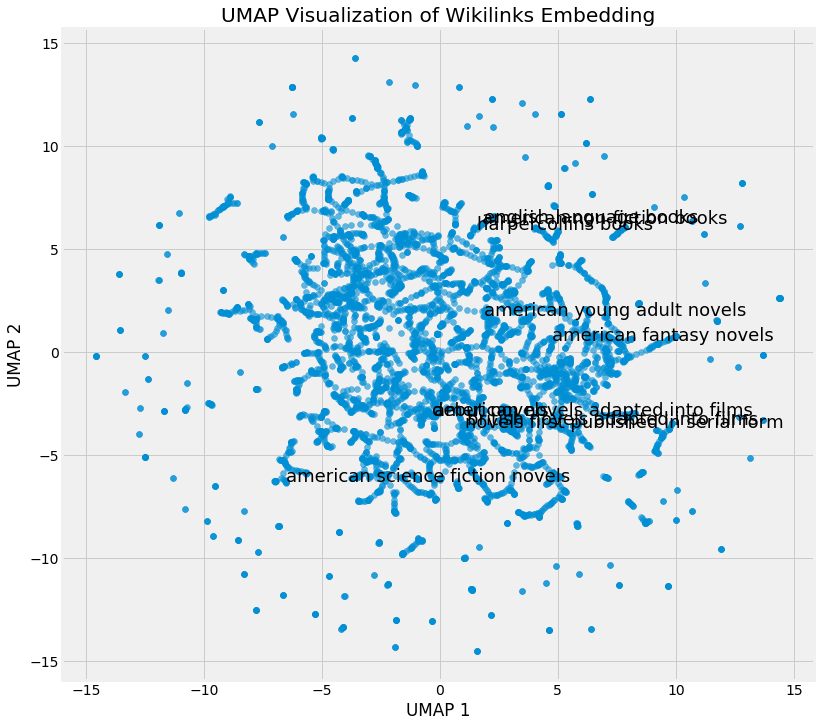

In [248]:
plt.figure(figsize = (12, 12))
plt.scatter(link_ru[:, 0], link_ru[:, 1], alpha = 0.6)

for i in idx:
    x, y = link_ru[i, 0], link_ru[i, 1]
    s = index_link[idx_to_include[i]].split(':')[-1]
    _ = plt.text(x, y, s, fontsize = 18);
    
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('UMAP Visualization of Wikilinks Embedding');

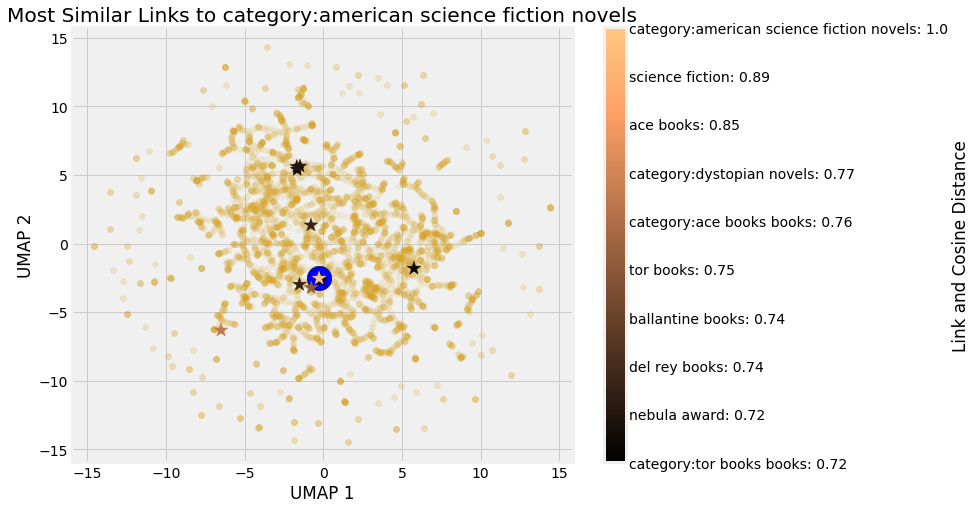

In [253]:
plot_closest('category:american science fiction novels', link_weights_acc, 'link', 10, link_ru)

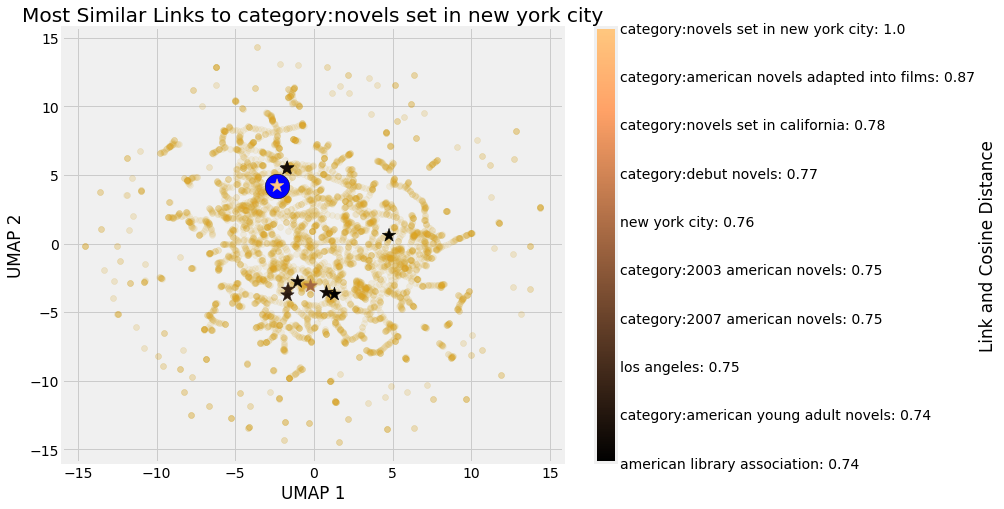

In [254]:
plot_closest('category:novels set in new york city', link_weights_acc, 'link', 10, link_ru)

Now we can go ahead and reduce the dimension of all the links. Then we can do the same as before, plotting the closest links.

In [255]:
link_ru = reduce_dim(link_weights_acc, components = 2, method = 'umap')
link_ru.shape

(38550, 2)

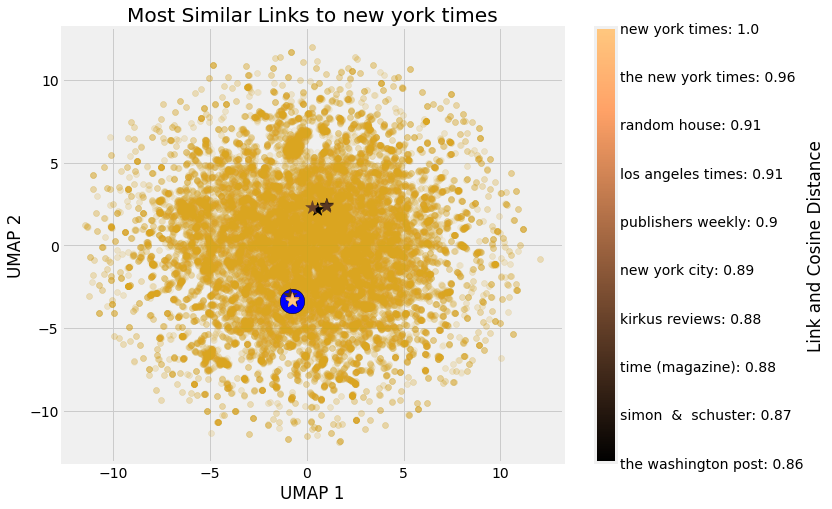

In [256]:
plot_closest('new york times', link_weights_acc, 'link', 10, link_ru)

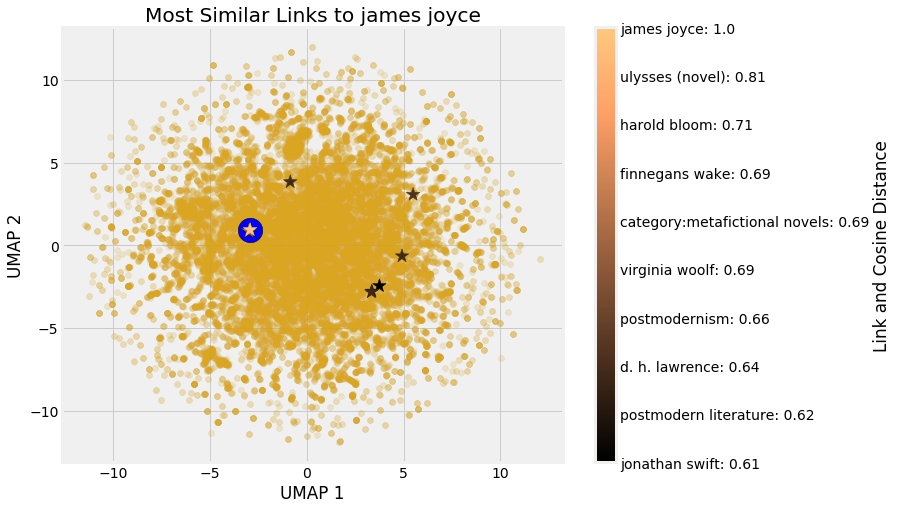

In [257]:
plot_closest('james joyce', link_weights_acc, 'link', 10, link_ru)

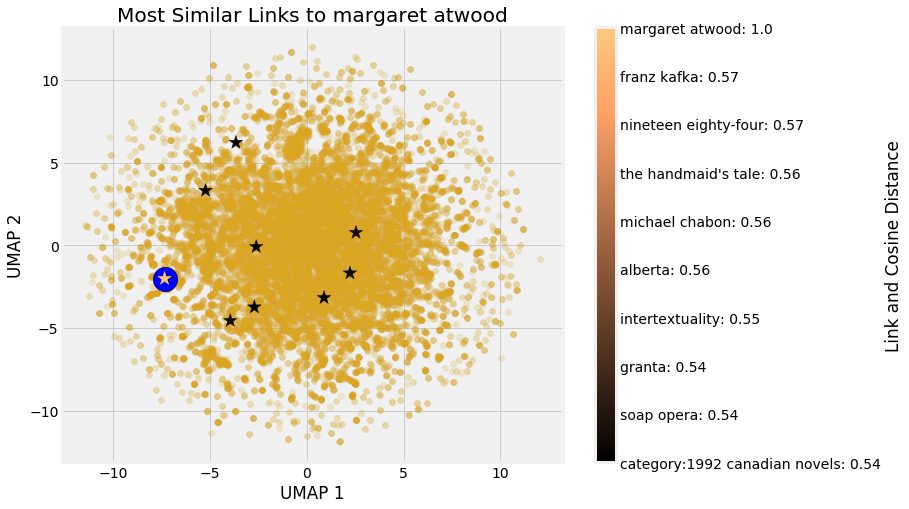

In [259]:
plot_closest('margaret atwood', link_weights_acc, 'link', 10, link_ru)

In [ ]:
link_names = pd.DataFrame({'name': link_index.keys()})
link_names.shape

In [ ]:
sorted([len(l) for l in links])[-10:]

# Save Embeddings for Visualization

We can save these embeddings for visualization in [projector.tensorflow.org](https://projector.tensorflow.org/)

In [ ]:
%%capture
pl = []
with open('link_names.tsv', 'w' , encoding = 'utf-8') as fout:
    for l in link_index.keys():
        try:
            fout.write(str(l))
            fout.write('\n')
        except:
            pl.append(l)

In [ ]:
np.save('book_embedding', book_weights_acc)
np.save('link_embedding', link_weights_acc)

In [ ]:
be = np.load('book_embedding.npy')
be.shape

In [ ]:
np.savetxt('book_embedding.tsv', book_weights_acc, delimiter='\t')
np.savetxt('link_embedding.tsv', link_weights_acc, delimiter='\t')

## Make Predictions

Of course the fun part is making predictions with the model. We can feed it any book and get the closest and furthest away books in the embedding space. 